# Notes:

## Content:

+ Negative Engineering
+ What is workflow orchestration?
+ Introduction to Prefect 2.0
+ First Prefect flow and Basics

## Workflow Orchestration

It's a set of tools that schedule and monitor work that you want to accomplish. Ex: Scheduling ML models training

Exmaple pipeline: 
```
PostgresQL -> Parquet -> Pandas -> Sklearn -> mlflow
                                      ↳ Rest API ↳ Flask (If deploying)
```
Random Points of Failure can occur in the pipeline. The goal of the workflow orchestration is to minimize the errors and fail
gracefully.

In more interconnected pipelines (Different pipelines interconnected) failure points are more commone.

## Negative Engineering
90% of engineering time is spent on:
+ Retries when APIs go down
+ Malformed data
+ Notifications
+ Observability into Failure
+ Conditional Failure Logic
+ Timeouts

Prefect's goal is to reduce this time to increase productivity; The goal is to reduce the time spent on Negative Engineering.

## Introducting Prefect:
Open Source Workflow Orchestration Framework for eliminating Negative Engineering:
+ Open Source
+ Python-based
+ Modern data stack
+ Native Dask integration
+ Very active Community
+ Prefect Cloud/Prefect Server -> Cloud is hosted by Prefect, Server Self-hosted.

## Building blocks of Prefect:

1. Tasks - think of them like regular python functions. They take input and produce an output. It has a decorator called @task before the function starts.
2. Flows -  it is also a function and they are responsible for serving as the container for workflow logic. Flows can be leveraged as parent functions used to call tasks and define state dependencies and data dependencies between tasks. It has a decorator called @flow before the function starts.
3. Subflows - flows can not only call tasks but they can call other flows too and this is called subflow. 

## Prefect UI:

We can open the Prefect UI using `prefect server start` to spin up a localhost instance. When you start the server, you'll see a message saying:
```
Configure Prefect to communicate with the server with:

    prefect config set PREFECT_API_URL=http://127.0.0.1:4200/api
```

Open up another terminal with the correct conda environment activated and run the command `prefect config set PREFECT_API_URL=http://127.0.0.1:4200/api`
The UI contains information and logs of varying detail about each flow run and where errors may have occured in the process
as well as error Stacktraces and task flows.

## Current state of Prefect:

+ Prefect Core (1.0)
+ Prefect Orion (2.0 beta)
+ Prefect uses Decorators to wrap the code.

## Deploying Notebooks:

We don't deploy notebooks, and if deployed they're deployed as a single step. Notebooks are thus refactored into scripts for
deployment

## Adding a  Prefect flow:

We implement Prefect in our code by wrapping the workflow function (which fetches the data, preprocesses it, trains the model...etc) with a `@flow` decorator as:

```python
from prefect import flow

@flow
def main():
  ...
```
This enables extra logging. 

The main function is what is usually put in a `if "__name"" == "__main__":` bloc wrapped as a function. (Name doesn't matter)

Multiple Flows can be put in the same file.

## Adding a Prefect task:

(Note: Prefect 1.0/2.0 difference: In 2.0 we can mix and match between normal functions and `@task` functions.
In 1.0 we couldn't)

We can then add tasks by using the `@task` decorator around our task function (example: preprocessing, training... etc):
```python
@task
def train_model(X,y):
  ...
```
The output of a function wrapped around a `@task` is a `PrefectFuture` object. If we're mixing and matching normal functions 
with `@task`ed functions we need to get the result of the function by calling `.result()` on the `PrefectFuture`. For example:
```python
from prefect import flow, task

X_train, X_val, y_train, y_val, dv = add_features(train_path, val_path).result()
```
Otherwise we'll just get the `PrefectFuture` object (likely with a crash).

Adding a task enables further logging.

Tasks can also have parameters like caching and retries.

## Section 3.4: Deploying your workflow

We are going to make a deployment that will live on a prefect server that's running locally in this case and it will allow us to do things like scheduling and in the future we can do collaboration with other folks for example if you're using prefect cloud.

Run `prefect project init` in the command line (ensuring you are in the right conda env with the requirements.txt installed). You'll see that it creates 4 files:
  - .prefectignore
  - deployment.yaml: usefule for templating if you're making multiple deployments from the same project
  - prefect.yaml
  - .prefect/: this is a hidden folder

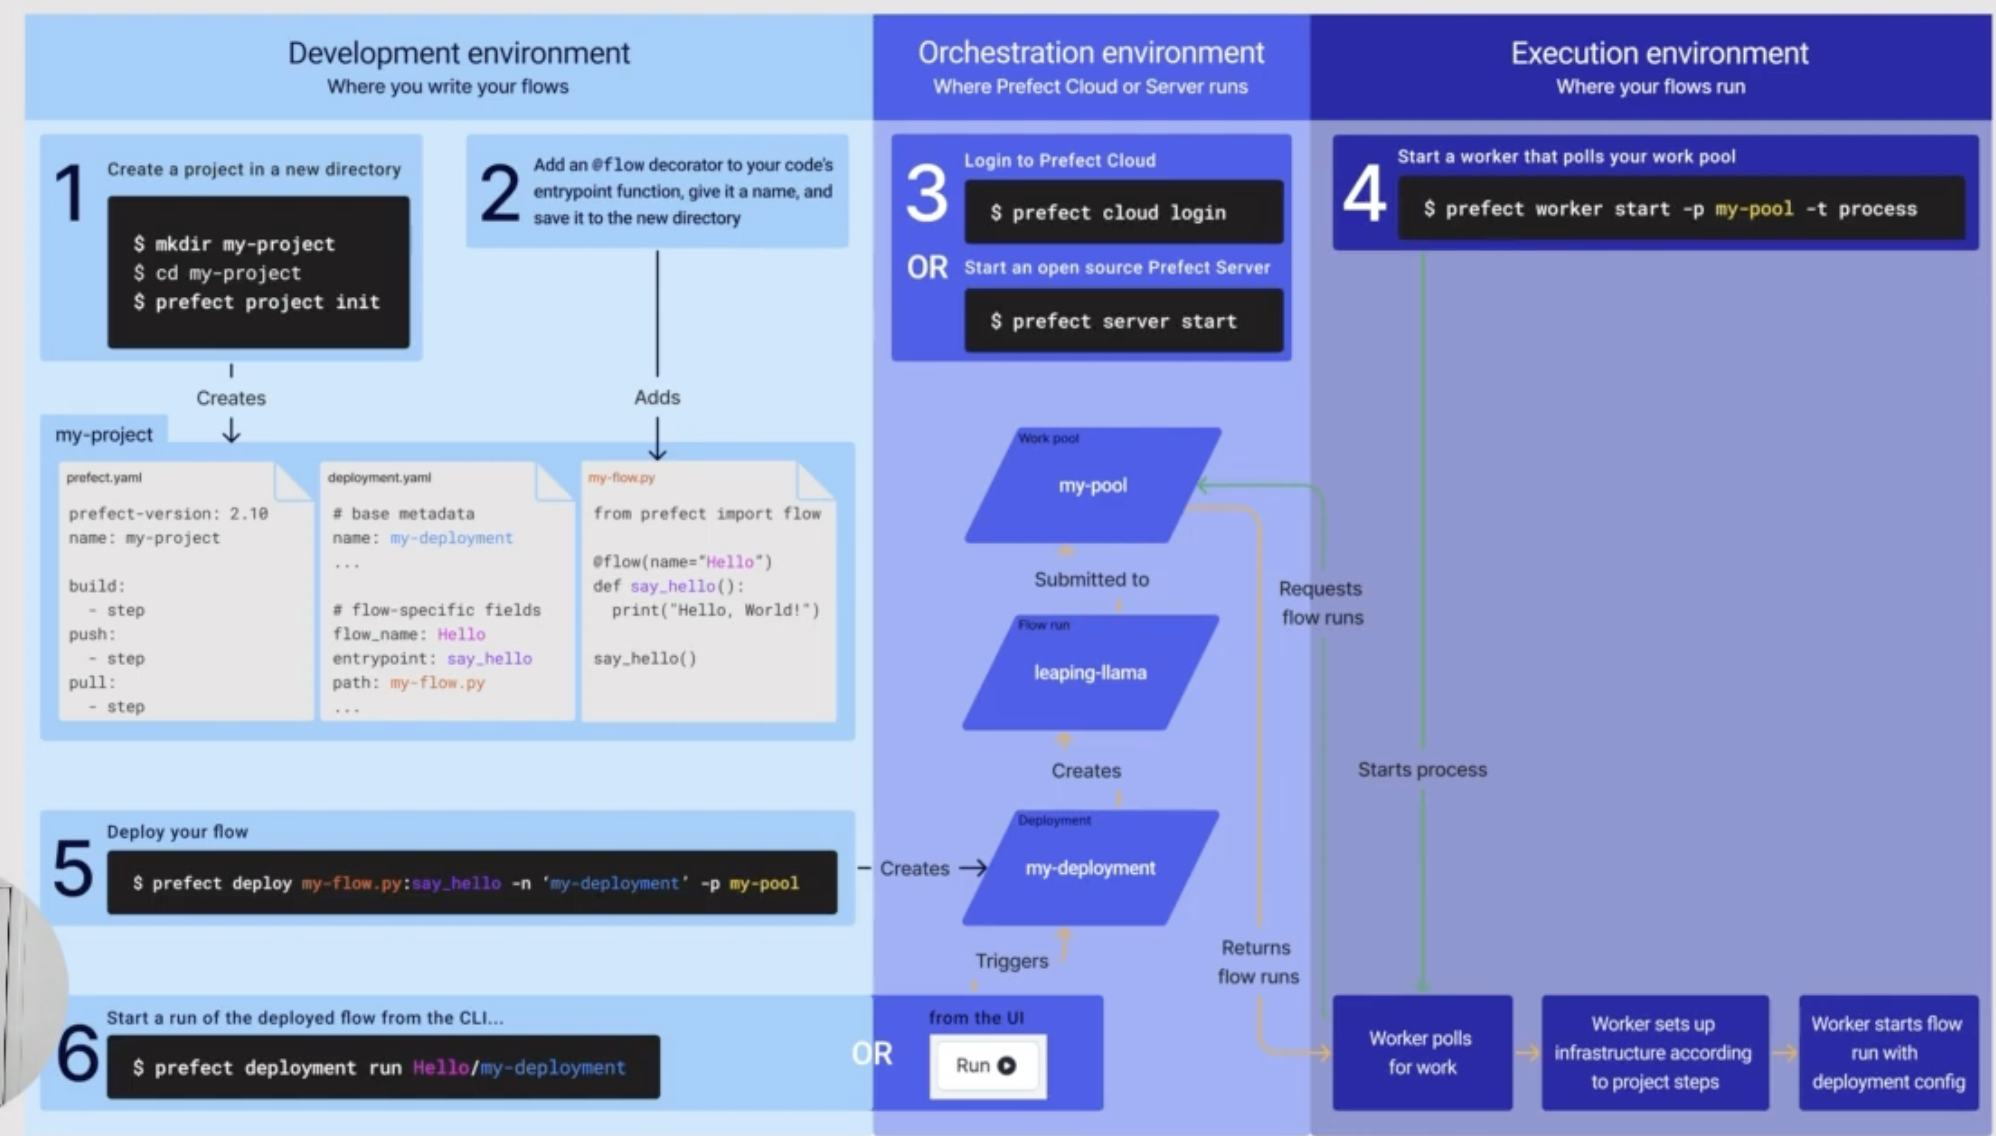

The above image is what we are trying to achieve in this section. 

We now need to create a worker to poll our work pool. Create the work pool using the UI and then run `prefect deploy 3.4/orchestrate.py:main_flow -n taxi1 -p zoompool` and then 

`prefect worker start -p zoompool`. If let's say you didn't create a zoompool using the UI, then you can run `prefect worker start -p zoompool -t process` and it will create the work pool called zoompool if it didn't already exist.

## Sequential Task Running:
If tasks don't depend on each other, Prefect will run the tasks asynchronously by default. This can't be handled by MLflow, so
in order to force sequential task running we add a parameter to the `@flow` decorator:

```python
from prefect import flow, task
from prefect.task_runners import SequentialTaskRunner
@flow(task_runner=SequentialTaskRunner())
def main():
  ...
```


# Homework:

### Q1. How can you specify a task name?

@task(retries=3, retry_delay_seconds=2, name="Read taxi data")

### Q.2 Schedule your deployment to run on the third day of every month at 9am UTC. What’s the cron schedule for that?

0 9 3 * *